## 0. Importing pytorch and setting up device agnostic

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1. Get data

Our dataset is subset of Food101 dataset

from 101 class we only take 3
we only take 10% of the whole image on Food101 (75 training, and 25 testing)
- When starting ML projects we can do small first then if model is ok we can add more later

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("Data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

image_path

Did not find Data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


PosixPath('Data/pizza_steak_sushi')

## 2. Becoming one with the data (data preperation and data exploration)

In [ ]:
# Code for checking inside the dataset
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk (dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'Data/pizza_steak_sushi
There are 3 directories and 0 images in 'Data/pizza_steak_sushi/test
There are 0 directories and 25 images in 'Data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in 'Data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in 'Data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in 'Data/pizza_steak_sushi/train
There are 0 directories and 78 images in 'Data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in 'Data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in 'Data/pizza_steak_sushi/train/sushi


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Data/pizza_steak_sushi/train'),
 PosixPath('Data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1.  Get all of the image paths
2. Pick a random image path using python random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Since were working with image, lets open the image with PIL
5. We'll then show the image and print metadata

Data/pizza_steak_sushi/train/pizza/3860002.jpg
pizza
Random image path: Data/pizza_steak_sushi/train/pizza/3860002.jpg
Image class: pizza
Image height : 512
Image width: 512


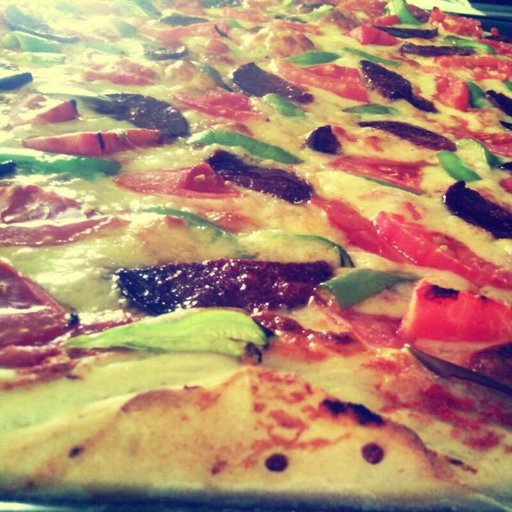

In [ ]:
import random
from PIL import Image

# Set seed for learning
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # What ever inside data, whatever inside test or train, the jpg file


# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

print(random_image_path)

# 3. Get image class from the path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height : {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

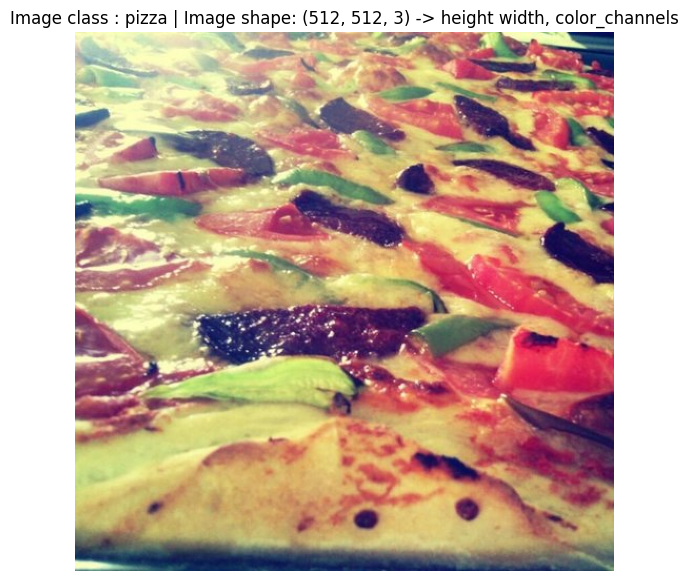

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with mathplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape: {img_as_array.shape} -> height width, color_channels")
plt.axis(False)

## 3. Transforming data

Before we can use image data with pytorch:
1. Turn target data into tensor (numerical representation of our images)
2. Turn it into a torch.utils.data.Dataset and subsquently a torch.utils.data.DataLoader for batch


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

Transforms help you get your images ready to be used with model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
    ])

In [ ]:
data_transform(img).dtype

torch.float32

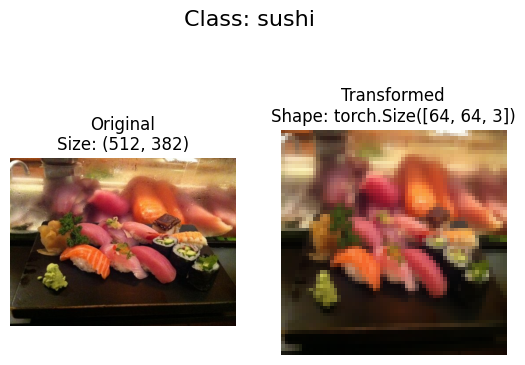

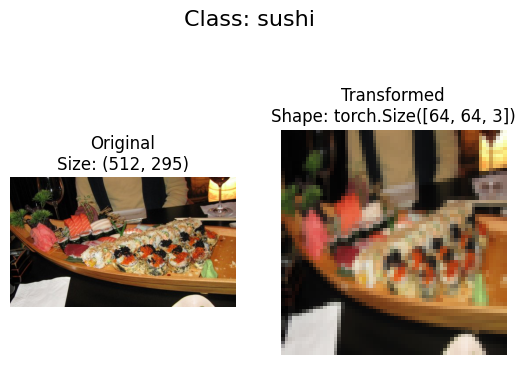

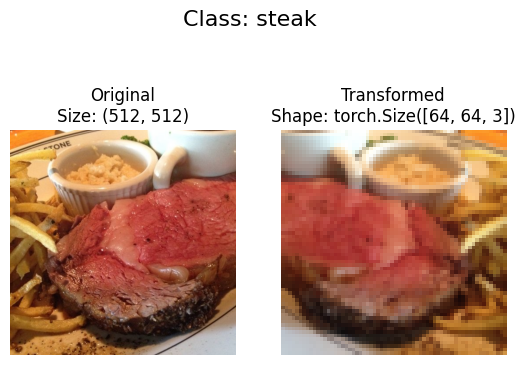

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transform them then plots the original
  vs the transformed version
  """

  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("Off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3
                        )

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using torchvision.datasets.ImageFolder

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for data
                                  target_transform=None) # A transform for label


test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: Data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class anamees as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype:{type(label)}")


Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [ ]:
label

0

Original shape: torch.Size([3, 64, 64]) -> [color, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

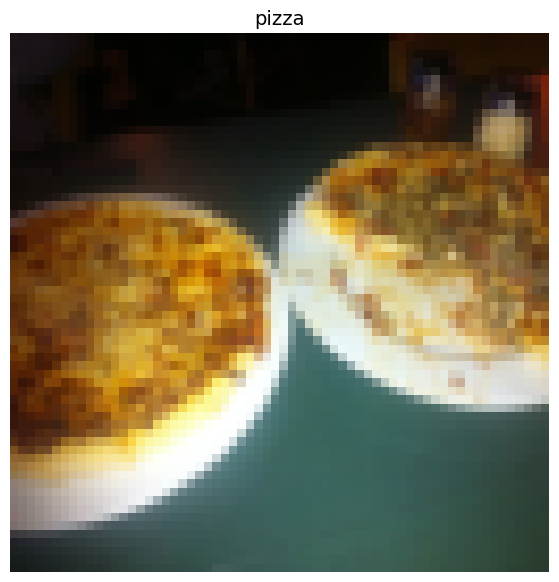

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Printout different shapes
print(f"Original shape: {img.shape} -> [color, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color]")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded image into DataLoader

**DataLoader** = help turn dataset to iterable and we can customize the batch_size so our model can see batch_size at a time

In [ ]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c73c0b098d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c73c0c4b590>)

In [ ]:
print(f"Batch size for train: {len(train_dataloader)} and test: {len(test_dataloader)}")

Batch size for train: 225 and test: 75


In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1 (you can change if you like it)
print(f"Image shape: {img.shape} -> [batch_size, color, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a custom Dataset
1. Able to load image from file
2. Able to get class from the Dataset
3. Able to get classes as dictionary from the Dataset

 **Pros**:
 * Can create a Dataset out of almost anything
 * Not limited to PyTorch pre-built Daataset functions

 **Cons**:
 * Even though you could create Dataset out of almost anything, it doesn't mean it will work
 * Using a custom Dataset often results in us writing more code, which could be prone to errors or perfomance issues


In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want function to:
1. Get the class names using os.scandir() to travererse a target directory
2. Raise an error if class names arent found (there might be something wrong with directory structure)
3. Turn the class names into a dict and list and return them


In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted ([entry.name for entry in list(os.scandir(target_directory))])

class_names_found


Target dir: Data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Cound find any classes in {directory}..... check file structure")

  # 3. Create a dictionary of index labels (computers prefer number than string)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder (Optioinal because pytorch already have this)

To create our own custom dataset, we want to:
1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (directory we like to get data) as well as a transform if we'd like to transform our data
3. Create several attribute:
* paths - paths of our images
* transform - transform we'd like to use
* classes - list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images(), this function will open an image
5. Overwrite the __len__() method to return the length of our dataset
6. Overwrite the __getitem__() method to return a given sample when passed an index

In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir : str,
               transform = None):

    # 3. Create several attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int):
    """Opens an image via apath and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. oVerwrite __len__()
  def __len__(self) -> int:
    "Returns the total numbe of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to reutnr a partucular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
     "Returns one sample of data, data and label (X, y)"
     img =self.load_image(index)
     class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
     class_idx = self.class_to_idx[class_name]

     # Transform if necessary
     if self.transform:
      return self.transform(img), class_idx #return
     else:
      return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64),),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir =train_dir,
                                     transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c73c0b5fa90>,
 <__main__.ImageFolderCustom at 0x7c73c0b65190>)

In [ ]:
len(train_data), len(train_data_custom) # same

(225, 225)

### 5.3 Create a function to display random images

1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, lets cap the number of images to see at 10
3. Set the random see just for learning
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample indexes and plot them with mathplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [ ]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldnt be larger than 10, setting to 10 and removing shape display")

    # 3. Set the seed
  if seed:
    random.seed(seed)

    # 4. Get random sample indexes
  random_sampples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
  plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sampples_idx):
      targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

      # 7. Adjust tensor dimensions for plotting
      targ_image_adjust = targ_image.permute(1,2,0) # [color, height, width] -> [height, widht, color]

      # Plot adjusted plot
      plt.subplot(1, n, i+1)
      plt.imshow(targ_image_adjust)
      plt.axis("off")
      if classes:
        title = f"Class: {classes[targ_label]}"
        if display_shape:
          title = title + f"\nShape: {targ_image_adjust.shape}"
      plt.title(title)


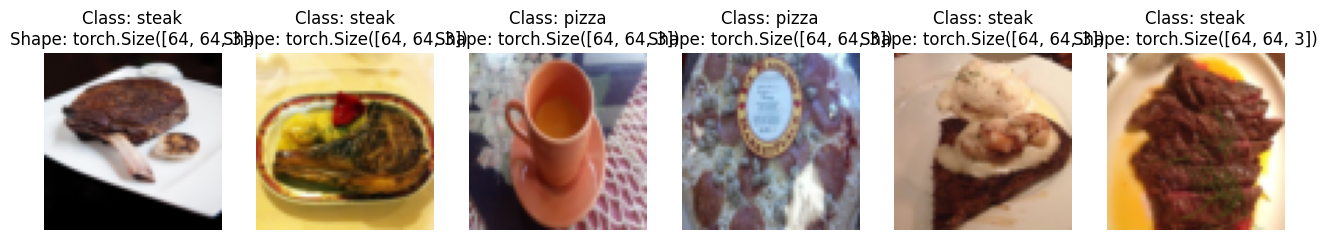

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=6,
                      classes=class_names,
                      seed=None)

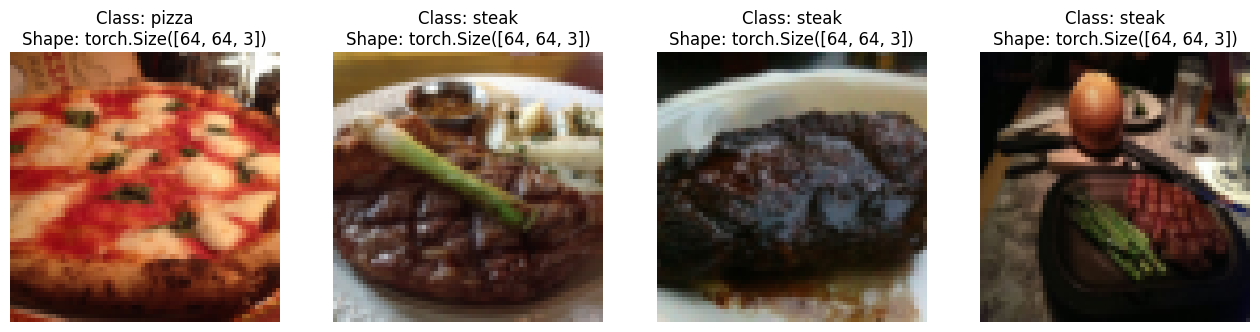

In [ ]:
# Display random images from the ImageFolderCUstom Dataset
display_random_images(train_data_custom,
                      n = 4,
                      classes = class_names,
                      seed=None)

### 5.4 Turning Dataset into Dataloader

In [ ]:
# Same from option 1
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c73c0b098d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c73c0c4b590>)

In [ ]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Data Augmentation

Data augmentation is the process of artificially adding diversity to your training data

This practice hopfully results in a model thats more generalizable to unseen data

In the case of image data, this may mean applying various image transformations to the training images



In [ ]:
# Trivialaugment (Contrast)
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])



In [ ]:
# Get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('Data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('Data/pizza_steak_sushi/test/pizza/1687143.jpg')]

In [ ]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 9,
    seed = None
)

Output hidden; open in https://colab.research.google.com to view.

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [ ]:
# Loading iamge data
from torchvision import datasets
train_data_0 = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform, # A transform for data
                                  target_transform=None) # A transform for label


test_data_0 = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform,
                                 )

In [ ]:
# Turn loaded image into Dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_0 = DataLoader(dataset=train_data_0,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader_0 = DataLoader(dataset = test_data_0,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader_0, test_dataloader_0

(<torch.utils.data.dataloader.DataLoader at 0x7c73c0b5ebd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c73c0a6a510>)

### 7.2 Creating the tinyVGG model

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_unit,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit,
                  out_channels = hidden_unit,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(), # Turn output from conv block into feature vector
        nn.Linear(in_features=hidden_unit*13*13,
                  out_features=output_shape)
    )

  def forward (self, x):
    x = self.conv_block_1(x)
    # Comment below for searching the classifier after that just comment it out
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_unit=10,
                  output_shape=len(class_names)).to(device)


model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_0))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get and idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torch

from torchinfo import summary

summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Perform one training epoch."""
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    return train_loss / len(data_loader), train_acc / len(data_loader)

In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0
  # Put model in eval mode
  model.eval()

  # Use inference mode
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (output raw logits)
      test_pred_logits = model(X)

      # 2. Calculate loss (accumulatively)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(y))

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the test loss average per batch
    test_acc /= len(data_loader)

    # Print out
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

  return test_loss, test_acc


In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device = device):
    """Full training loop for multiple epochs."""
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch {epoch+1}: "
              f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
              f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 7.6 Training and evaluate model 0

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of tinyVGG
model_0 = TinyVGG(input_shape= 3, # number of color channels
                  hidden_unit= 10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss func and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),
                             lr = 0.01)

# Start the timer
from timeit import default_timer as timer
start_timer = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_0,
                        test_dataloader = test_dataloader_0,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")

Test loss: 1.10072 | Test acc: 0.20%
Epoch 1: Train loss: 1.1263 | Train acc: 0.3086 | Test loss: 1.1007 | Test acc: 0.1979
Test loss: 1.10878 | Test acc: 0.20%
Epoch 2: Train loss: 1.1022 | Train acc: 0.2930 | Test loss: 1.1088 | Test acc: 0.1979
Test loss: 1.10578 | Test acc: 0.20%
Epoch 3: Train loss: 1.1012 | Train acc: 0.2930 | Test loss: 1.1058 | Test acc: 0.1979
Test loss: 1.10465 | Test acc: 0.20%
Epoch 4: Train loss: 1.1012 | Train acc: 0.2930 | Test loss: 1.1046 | Test acc: 0.1979
Test loss: 1.09971 | Test acc: 0.26%
Epoch 5: Train loss: 1.0986 | Train acc: 0.2930 | Test loss: 1.0997 | Test acc: 0.2604
Test loss: 1.10114 | Test acc: 0.26%
Epoch 6: Train loss: 1.1001 | Train acc: 0.3047 | Test loss: 1.1011 | Test acc: 0.2604
Test loss: 1.10433 | Test acc: 0.26%
Epoch 7: Train loss: 1.1010 | Train acc: 0.3047 | Test loss: 1.1043 | Test acc: 0.2604
Test loss: 1.10126 | Test acc: 0.26%
Epoch 8: Train loss: 1.0962 | Train acc: 0.4258 | Test loss: 1.1013 | Test acc: 0.2604
Test los

### 7.7 Plot the loss curve over model_0

Track the result of our model

In [ ]:
# Get the model_0 keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plot training raining curves of a results dictionary."""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

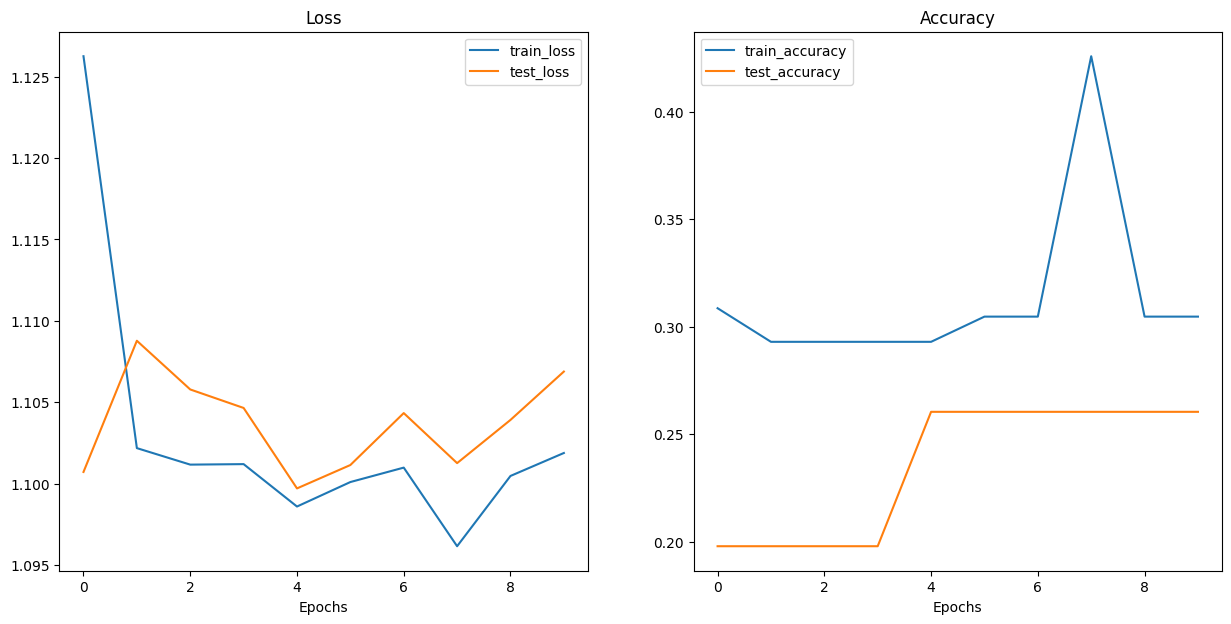

In [ ]:
plot_loss_curves(model_0_results)


# Screenshot 5 epochs and 30 or more epochs on week meet

## 8. What should an ideal loss curve look like
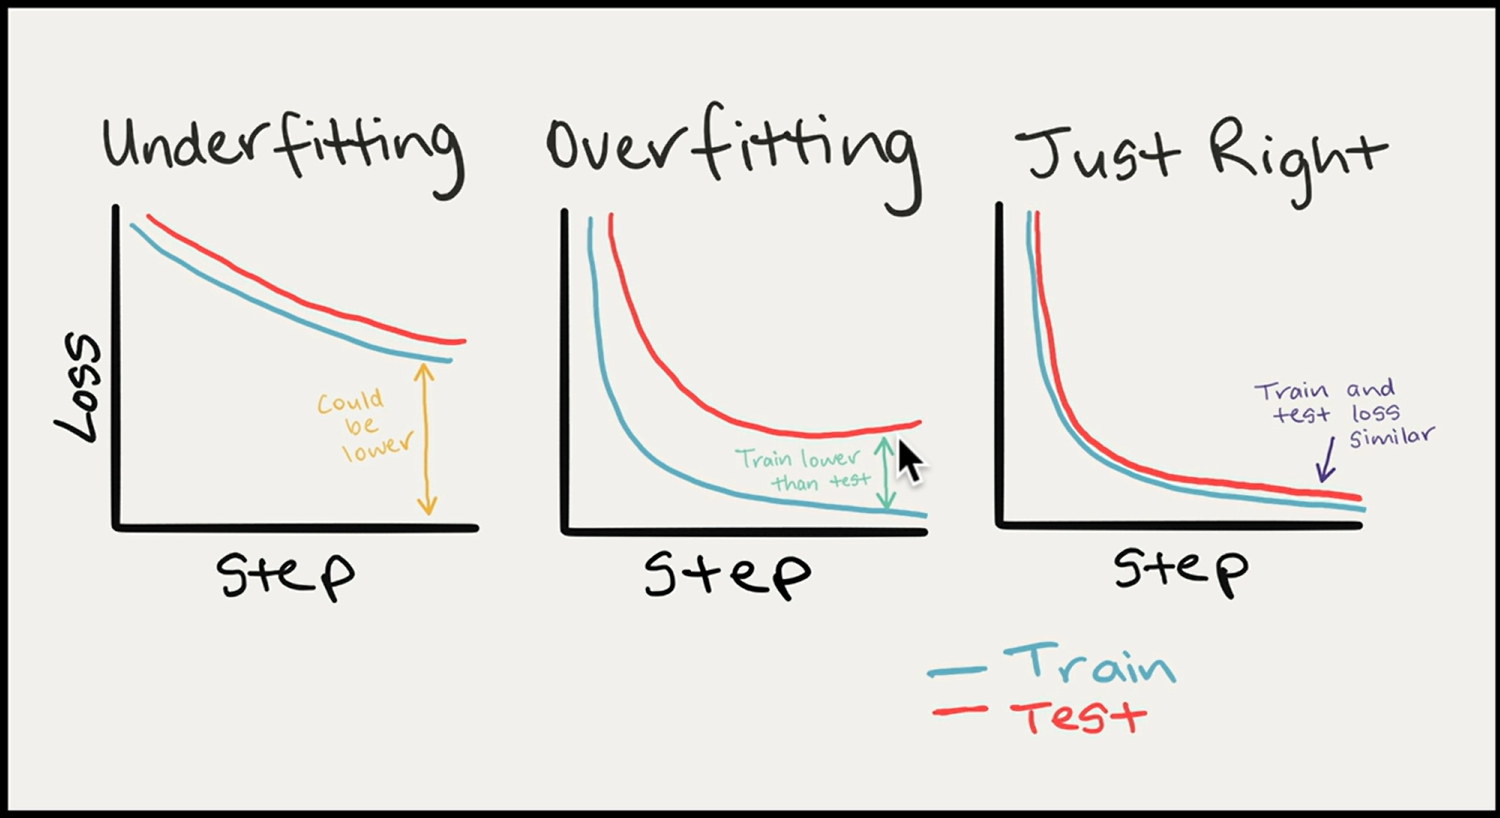

## 9. Model 1: TinyVGG with data augmentation

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


### 9.2 Create train and test Datasets and Dataloader with data augmentation

In [ ]:
# Turn image folder into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform= train_transform_trivial,
                                            )

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = test_transform_simple)



In [ ]:
# Turm dataset into data loader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)



### 9.3 Construct and train model 1
This time i use same model architect but with augmented data

In [ ]:
# Create model_1 and send it to target device
model_1 = TinyVGG(input_shape=3,
                  hidden_unit=10,
                  output_shape=len(train_data_augmented.classes
                                   )).to(device)



In [ ]:
# Create loss function and optimizer and call train() to train and evaluate

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer
start_timer = timer()

# Train model 1
model_1_results = train(model = model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total train time: {end_timer - start_timer:.3f} seconds")

Test loss: 1.12077 | Test acc: 0.26%
Epoch 1: Train loss: 1.0934 | Train acc: 0.3828 | Test loss: 1.1208 | Test acc: 0.2604
Test loss: 1.12225 | Test acc: 0.26%
Epoch 2: Train loss: 1.1151 | Train acc: 0.3047 | Test loss: 1.1223 | Test acc: 0.2604
Test loss: 1.12596 | Test acc: 0.26%
Epoch 3: Train loss: 1.1122 | Train acc: 0.3047 | Test loss: 1.1260 | Test acc: 0.2604
Test loss: 1.10614 | Test acc: 0.26%
Epoch 4: Train loss: 1.0939 | Train acc: 0.4258 | Test loss: 1.1061 | Test acc: 0.2604
Test loss: 1.10649 | Test acc: 0.26%
Epoch 5: Train loss: 1.0911 | Train acc: 0.4258 | Test loss: 1.1065 | Test acc: 0.2604
Test loss: 1.11667 | Test acc: 0.26%
Epoch 6: Train loss: 1.1078 | Train acc: 0.3047 | Test loss: 1.1167 | Test acc: 0.2604
Test loss: 1.09507 | Test acc: 0.26%
Epoch 7: Train loss: 1.1054 | Train acc: 0.3047 | Test loss: 1.0951 | Test acc: 0.2604
Test loss: 1.10181 | Test acc: 0.26%
Epoch 8: Train loss: 1.1002 | Train acc: 0.3047 | Test loss: 1.1018 | Test acc: 0.2604
Test los

### 9.4 Plot the model
Help for evaluate model performance overtime

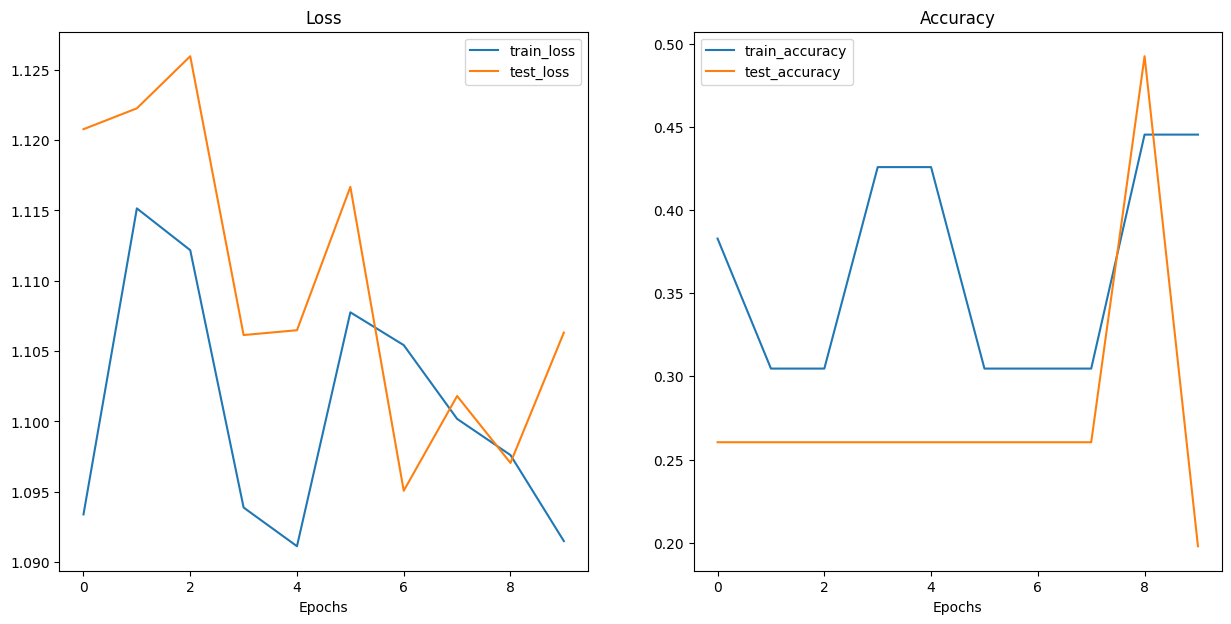

In [ ]:
plot_loss_curves(model_1_results)

## 10 Compare model results
After evaluating model its important to compare each other

Way to do:
1. Hard coding (right now)
2. Pytorch + Tensorboard
3. Weights and biases
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.126253,0.308594,1.100716,0.197917
1,1.102181,0.292969,1.108776,0.197917
2,1.101168,0.292969,1.105784,0.197917
3,1.101198,0.292969,1.104648,0.197917
4,1.098594,0.292969,1.099706,0.260417
5,1.100098,0.304688,1.101143,0.260417
6,1.100984,0.304688,1.104333,0.260417
7,1.096156,0.425781,1.101260,0.260417
8,1.100472,0.304688,1.103914,0.260417
9,1.101882,0.304688,1.106883,0.260417


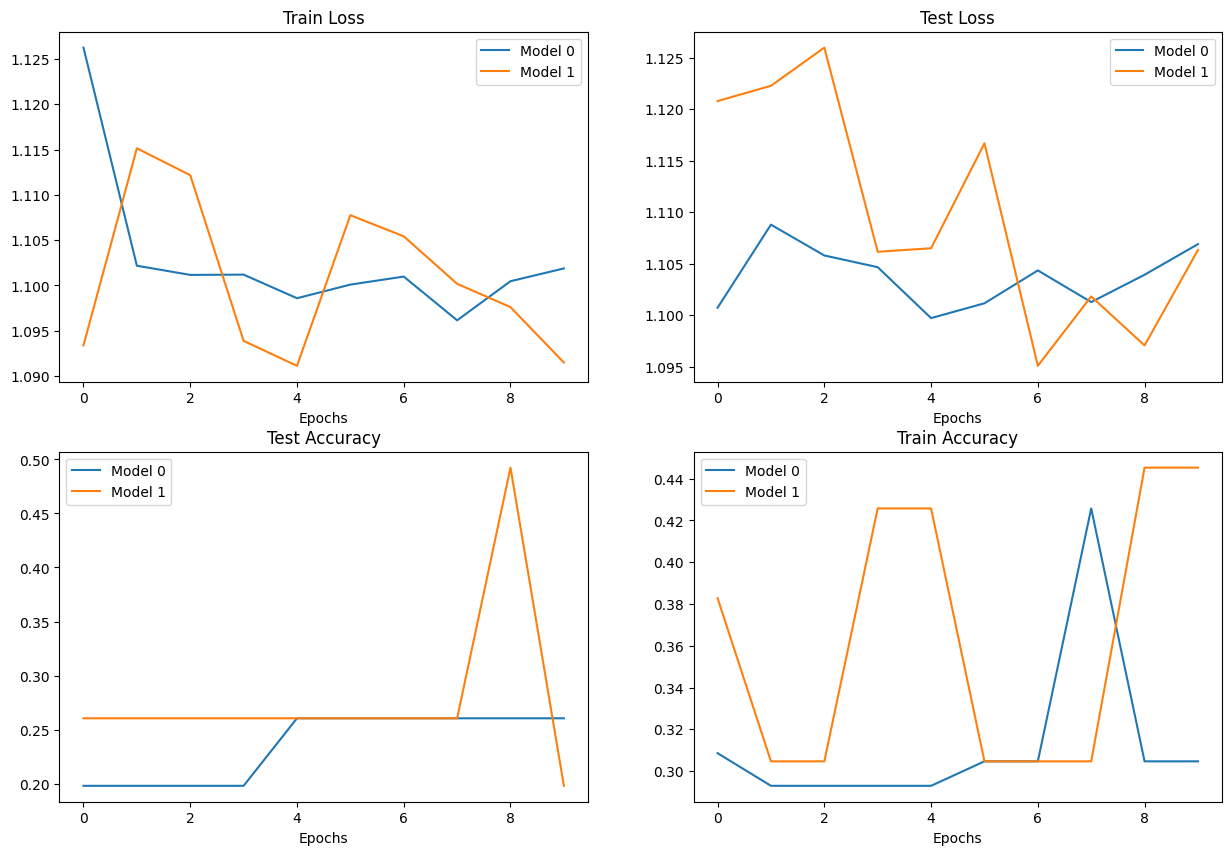

In [ ]:
# Setup a plot
plt.figure(figsize = (15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making prediction on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

Data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with pytorch

Need to make sure custom image is in the same format as the data our model was trained on

* In tensor form with datatype (torch.float32)
* Shape 64x64x3
* Right device

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

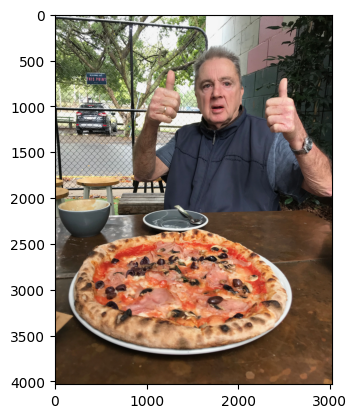

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained pytorch model

In [ ]:
# Try to make a prediction on an image in uint8 format (JUST TO SHOW WILL ERROR IF WE DONT CONVERT FIRST TO SAME TYPE)
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load the custom image and convert to float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) /255
custom_image

<function Tensor.type>

In [ ]:
# Create transform pipeine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transforms target image
custom_image_transform = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transform.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


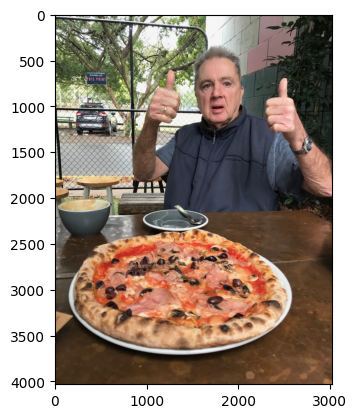

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
custom_image_transform.shape

torch.Size([3, 64, 64])

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transform.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.4620, -2.1982, -0.8722]])

In [ ]:
class_names

['pizza', 'steak', 'sushi']

Note, to make a prediction on acustom image we had to:
* Load the image and turn it to tensor
* Make sure the image was the same datatype as the mode (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3x64x64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_prob = torch.softmax(custom_image_pred, dim=1) #using softmax because we working with multiclass classification data
custom_image_pred_prob

tensor([[0.7500, 0.0525, 0.1975]])

In [ ]:
# Convert prediction probabilites -> prediction lables
custom_image_pred_labels = torch.argmax(custom_image_pred_prob, dim=1)
custom_image_pred_labels

tensor([0])

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

In [ ]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transform.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transform.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transform.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


### 11.3 Putting custom image prediction together: building a function

Ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
# Print shapes for debugging
print(f"Original image shape: {custom_image.shape}")
print(f"Transformed image shape: {custom_image_transform.shape}")
print(f"Prediction: {class_names[custom_image_pred_labels.cpu()]}")
print(f"Prediction probability: {custom_image_pred_prob.max().cpu():.3f}")

Original image shape: torch.Size([3, 4032, 3024])
Transformed image shape: torch.Size([3, 64, 64])
Prediction: pizza
Prediction probability: 0.750


In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device=device)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

## 12. Self learn

### 12.1 Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Improve the input data, make sure to clean the data as good as possible free from error if possible
2. Use data augmentatition to increase the data variety and make the model train to various type
3. Transfer learning can be applied using a model that is already good with solving problem

### 12.2 Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [ ]:
# Import torch
import torch
from torch import nn

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# 1. Get the data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("Data Excercise/")

# If the image folder doesn't exist, download
if image_path.is_dir():
  print(f"{image_path} directory exist")
else:
  print(f"Creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = request.get("https:///github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

  # Unzip it
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as z:
    print("Unzipping")
    zip_ref.extracall(image_path)


Data/pizza_steak_sushi directory exist


In [ ]:
# Become one with the data
import os
def walk_through_dir